# Training an image classifier

### Environment

Checking internet connection

In [72]:
import socket,warnings, os
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [73]:
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *
import time, json

### Downloading images of flowers

In [74]:
def search_images(keywords, max_images=200): 
    return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

#### Example : 

Fetch a url 

In [75]:
urls = search_images('primrose photo', max_images=1)
urls[0]

'https://cdn.pixabay.com/photo/2021/03/11/19/26/primrose-6087961_1280.jpg'

download the picture

In [76]:
dest = 'primrose.jpg'
download_url(urls[0], dest, show_progress=False)

Path('primrose.jpg')

and show file

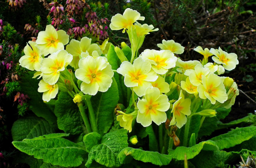

In [77]:
im = Image.open(dest)
im.to_thumb(256,256)

#### Downloading data

In [79]:
os.makedirs("flower_data/", exist_ok = True)
searches = ['primrose','orchid', 'tulip', 'geranium', 'rose']
path = Path('flower_data')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} flower photo', max_images = 300))
    time.sleep(1)
    resize_images(path/o, max_size=400, dest=path/o)

/opt/conda/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in by

Removing images where downloading failed

In [80]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

29

### Training the model

Building a dataloader 

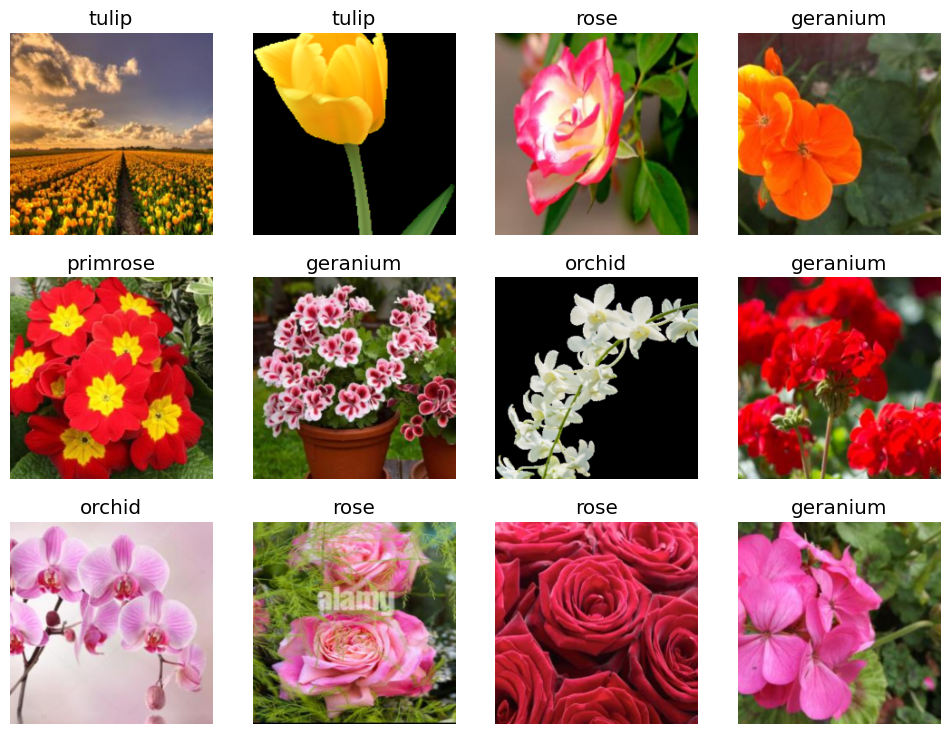

In [81]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5)
).dataloaders(path, bs=32)

dls.show_batch(max_n=12)

In [82]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.749115,0.342514,0.109375,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.355044,0.187270,0.060156,00:22
1,0.197134,0.112657,0.032031,00:23
2,0.100160,0.071225,0.022656,00:23
3,0.051653,0.057574,0.017188,00:24


### Data cleaning

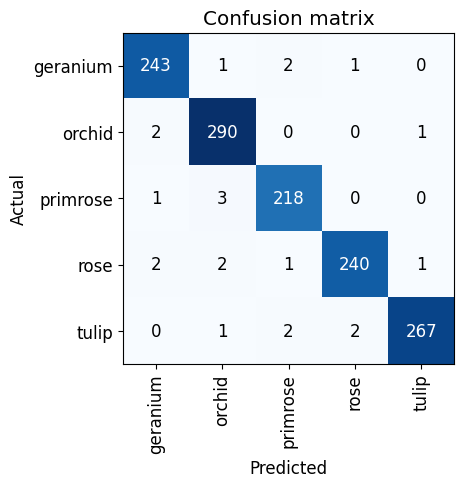

In [83]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Most important losses : 

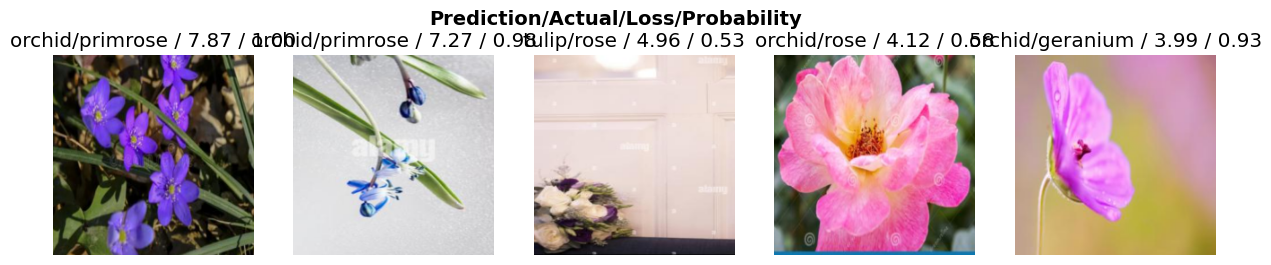

In [84]:
interp.plot_top_losses(5, nrows=1)

### Using the model

In [85]:
is_prim,_,probs = learn.predict(PILImage.create('primrose.jpg'))
print(f"This is a: {is_prim}.")
print(f"Probability it's a {is_prim}: {max(probs):.4f}")

This is a: primrose.
Probability it's a primrose: 1.0000


### Exporting the model

In [87]:
os.makedirs("models/", exist_ok = True)

In [88]:
learn.export('models/first_classifier.pkl')